# Benchmarking

In [1]:
import pyrfume
import pyrfume.benchmarking as pbm
import pandas as pd

In machine learning, benchmarking is the process of obectively comparing and evaluating the performance of different models or algorithms on a standardized set of tasks or datasets. It's main objectives are performance evaluation, progress tracking, standardization, and model selection. Benchmarking is particularly important in the field of machine olfaction due to the unique challenges and characteristics associated with odor sensing and analysis. Feature spaces can be quite high dimensional, and measurements are very heterogeneous and multi-modal. 

The <span style="font-family: courier new">pyrfume.benchmarking</span> module is built upon [Sklearn's](https://scikit-learn.org/stable/index.html) tools for prediction (classification and regression) to serve as a self-contained source for establishing benchmarks in the `Pyrfume-Data` repository. The benchmarking module provides a simplified syntax and workflow for quickly evaluating models in olfaction, across a variety of tasks, algorithms, feature sets, and measurement modalities (perceptual data, imaging, ephys, etc).

To illustrate the functionality of the <span style="font-family: courier new">pyrfume.benchmarking</span> module, we'll look at predicting primary odor using percept data from the [Sharma et al. 2021b](https://academic.oup.com/nar/article/50/D1/D678/6362078) archive.

## Preparing a dataset
Because of the many nuances inherent to experimental data in general, and the idiosyncracies of olfaction data in particular, preparing a `Pyrfume-Data` archive for an ML benchmarking pipeline will typically be archive specific. We'll begin by examining one of the behavior files from this archive.

In [2]:
archive = 'sharma_2021b'

# Load behavior data
behavior = pyrfume.load_data(f'{archive}/behavior_1.csv')
behavior = behavior[~behavior.index.duplicated()] # Remove any duplicate molecules
behavior.head()

,Primary Odor,Sub Odor,Strength
Stimulus,,,
4,Ammonia,Fishy,NaN
19,Odorless,NaN,NaN
49,Fragrant/Fruity,Fruity,NaN
51,Odorless,NaN,NaN
58,Brown,Brown,NaN


A quick look at <span style="font-family: courier new">stimuli.csv</span> confirms the stimlus index is just the molecule CIDs. (i.e. there are no mixtures, no compound or 'natural' odorants ('cloves', 'coffee', etc), and no stimulus conditions to consider beyond the odorant id (concentration, duration, pairing w/reinforcer etc).  

In [3]:
# Load stimuli info
stimuli = pyrfume.load_data(f'{archive}/stimuli.csv')
stimuli.head()

,CID
Stimulus,
4,4
19,19
49,49
51,51
58,58


We are now ready to create an instance of a PyrfumeDataset. This is a class that encapsulates data and metadata about odorants that are needed/useful for prediction, including the feature set being used ('Mordred', 'Morgan', etc), the ML task being performed ('regression', 'classification'), etc. 

We will use 'Primary Odor' as our prediction target and the precomputed Mordred features (see [Part 3](./featurization)) to represent our molecules in feature space. In plain language: we're trying to predict whether a given chemical smells 'Fragrant', 'Fishy', 'Odorless', etc, from measured (or computed) characteristics (# Carbons, boiling point, etc). To create a <span style="font-family: courier new">PyrfumeDataset</span> instance, we provide the archive name, a Pandas DataFrame indexed on CID and containing (at a minimum) our prediction target, the name of the molecule features, and specify the task as 'classification' or 'regression'. A typical classification task might involve predicting which one of a handful of odor classes an chemical belongs to. A typical regression task might involve predicting a what a given chemical's detection threshold will be. 

During initialization the <span style="font-family: courier new">PyrfumeDataset</span> class will load the specified feature set and add the molecule features for each CID. Alternatively, <span style="font-family: courier new">feature_set</span> can be set to <span style="font-family: courier new">None</span> and molecule features can be added later using the class's <span style="font-family: courier new">add_features()</span> method. This approach allows the use of molecule features other than the precomputed Mordred or Morgan similarity fingerprints. The <span style="font-family: courier new">describe()</span> method prints a summary of the dataset's attributes.

In [4]:
# Create a PyrfumeDataset class
dataset = pbm.PyrfumeDataset(
    archive=archive,
    df=behavior[['Primary Odor']].rename_axis('CID'),
    feature_set='mordred',
    task='classification'
)

# Summary of our dataset
dataset.describe()

Loading features...
Returned 1332 features for 5026 molecules
--------------------------------------------------
Archive: sharma_2021b
Prediction target: Primary Odor
# molecules: 5026
Molecule features: mordred
# features: 1332
ML task: classification
n_splits: 2

        Primary Odor       ABC     ABCGG
CID                                     
4            Ammonia  3.047207  3.305183
19          Odorless  8.094413  7.861189
49   Fragrant/Fruity  5.415816  5.894012
51          Odorless  6.870470  7.091508
58             Brown  4.530370  5.004088
--------------------------------------------------


In an ML classification task, it may be necessary to filter the data to remove instances that have infrequently used labels, and to encode text labels to numerical form. The <span style="font-family: courier new">PyrfumeDataset</span> class contains methods that perform these operations for us.

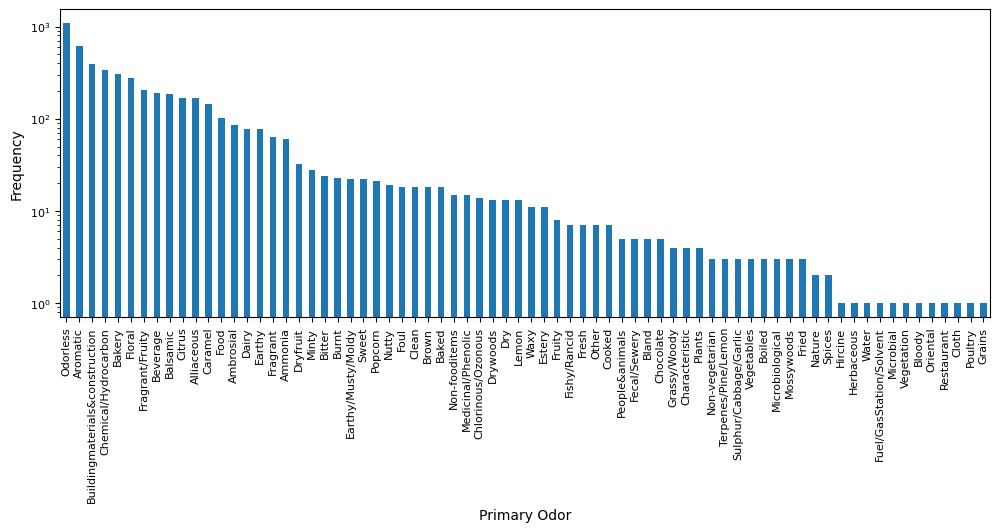

In [5]:
# Plot distribution of label use
dataset.plot_target_distribution()

In [6]:
# Filter out instances where labels are used less than 10 times
dataset.threshold_labels(min_counts=10)

# Encode labels
dataset.encode_labels()

The label distribution plots shows that many labels are used only a few times. After filtering out labels used less than 10 times, we see below that 4918 molecules remain from the inital 5026. As a result of applying the <span style="font-family: courier new">encode_labels()</span> method the primary odors have now been mapped to integer values. Also, note that <span style="font-family: courier new">n_splits</span> has increased from 2 to 5. <span style="font-family: courier new">n_splits</span> is the number of folds to use during cross-validation, and by default the <span style="font-family: courier new">PyrfumeDataset</span> class will set the number of folds equal to half the number of instances of the least used label (rounded down). This default can be overridden using the <span style="font-family: courier new">set_n_splits()</span> method. However, beware that <span style="font-family: courier new">sklearn</span> cross-validator objects require lower-bounds on the  <span style="font-family: courier new">n_splits</span> parameter.

In [7]:
dataset.describe()

--------------------------------------------------
Archive: sharma_2021b
Prediction target: Primary Odor
# molecules: 4918
Molecule features: mordred
# features: 1332
ML task: classification
n_splits: 5

     Primary Odor       ABC     ABCGG
CID                                  
4               2  3.047207  3.305183
19             34  8.094413  7.861189
49             28  5.415816  5.894012
51             34  6.870470  7.091508
58              9  4.530370  5.004088
--------------------------------------------------


## Prepare the estimator pipeline
Our behavior data are now in pipeline-ready format. We next create an ML estimator pipeline. The <span style="font-family: courier new">pyrfume.benchmarking</span> module provides a <span style="font-family: courier new">Model</span> class to standardize these benchmarking pipelines as well as a number of preconfiguired Sklearn classification and regression algorithms. Below we list the available methods for classification.

In [8]:
# List pre-configured classificaion algorithms
', '.join(pbm.list_default_estimators('classification'))

'LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, BernoulliNB, ExtraTreesClassifier, GradientBoostingClassifier, KNeighborsClassifier, MultinomialNB, SVC, XGBClassifier, MLPClassifier'

As a first attempt, we'll try the Bernoulli Naive Bayes algorithm. We can quickly view the default parameter space for <span style="font-family: courier new">BernoulliNB</span> by using the <span style="font-family: courier new">get_default_parameters</span> function. For computational expediency in this tutorial, we will replace the default parameter grid with a more limited range of values at the time of intializing our <span style="font-family: courier new">Model</span> instance. Note that a parameter grid can also be specified after initializing a <span style="font-family: courier new">Model</span> instance by using the <span style="font-family: courier new">set_parameter_grid</span> method.

In [9]:
# Show default parameter grid for Bernoulli Naive Bayes algorithm
pbm.get_default_parameters('BernoulliNB')

{'alpha': [0, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 25, 50],
 'fit_prior': [True, False],
 'binarize': [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]}

In [10]:
# Create pipeline using Bernoulli Naive Bayes algorithm and a custom parameter grid
reduced_param_grid = {'alpha': [0.1, 1, 10], 'fit_prior': [True, False], 'binarize': [0.25, 0.5, 0.75]}
pipeline = pbm.Model('BernoulliNB', param_grid=reduced_param_grid)

# Description of the pipeline
pipeline.describe()

Pipeline: MinMaxScaler;BernoulliNB
Parameter grid: {'bernoullinb': {'alpha': [0.1, 1, 10], 'fit_prior': [True, False], 'binarize': [0.25, 0.5, 0.75]}}
Scoring: ['balanced_accuracy', 'accuracy', 'f1_macro', 'f1_weighted', 'roc_auc_ovr_weighted']
Task: classification



Note that our classification pipeline also contains a preprocessing step to rescale the molecule features using sklearn's <span style="font-family: courier new">MinMaxScaler</span>. This preprocessor was added in during initialization of the <span style="font-family: courier new">Model</span> class since the <span style="font-family: courier new">BernoulliNB</span> algorithm (as do certain other algorithms) expects feature values between 0 and 1. Recall from [Part 3](./featurization) that the Morgan and Mordred feature sets were scaled using <span style="font-family: courier new">StandardScaler</span>.

More generally, an estimator pipeline can be created using the <span style="font-family: courier new">Model</span> class by providing a list of sklearn methods for preprocessing, dimensionality reduciton, and a classification/regresson estimator (note that the last step of the list must be an estimator). For any non-preconfigured pipeline, a parameter grid (to be used with <span style="font-family: courier new">GridSearchCV</span>) must also be specified. Additional steps (e.g feature scaling or dimensionality reduction) can be added to any pipeline using the <span style="font-family: courier new">Model</span> class's <span style="font-family: courier new">add_step</span> method. If not specified during initialization, default scoring metrics will be provided depending on whether our task is classification or regression.

## Feature selection
During retireval, molecule features with zero variance are automatically removed. However, not all features that are returned are guaranteed to be informative. For our current dataset we can plot the correlation among Mordred features and see that there is a significant amount of correlation between features.

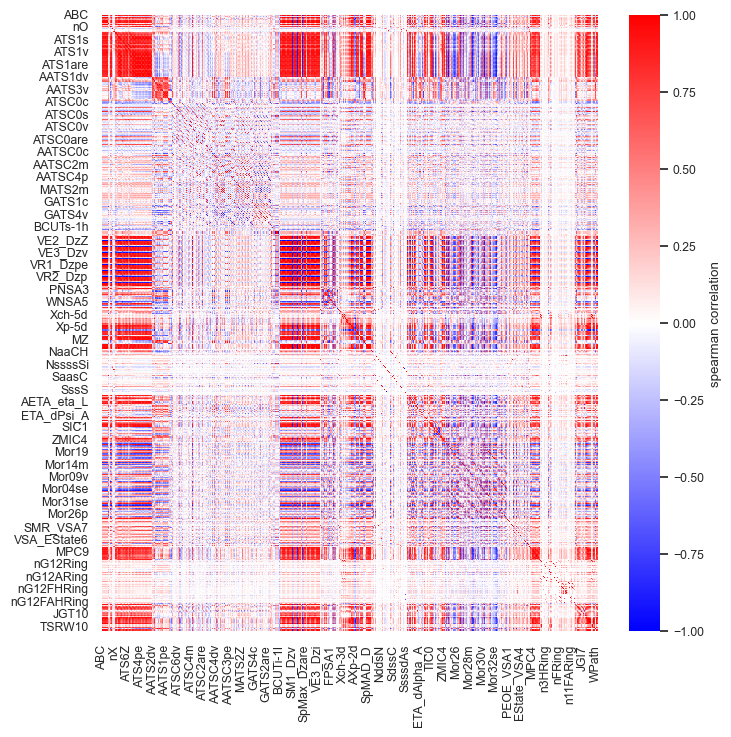

In [11]:
# Plot feature correlations
dataset.plot_feature_correlations()

The <span style="font-family: courier new">pyrfume.benchmarking</span> module also provides methods for feature selection using the options available through Sklearn's <span style="font-family: courier new">GenericUnivariateSelect</span>. The number of molecule features can be reduced for a <span style="font-family: courier new">PyrfumeDataset</span> instance using the <span style="font-family: courier new">select_features</span> method or as part of a <span style="font-family: courier new">GridSearchCV</span> optimization by using the <span style="font-family: courier new">add_feature_selection</span> method from the <span style="font-family: courier new">Model</span> class. Here we will add a 'select k best' feature selection step to our pipeline that will get optimized during <span style="font-family: courier new">GridSearchCV</span>.

In [12]:
# Add feature selection step to the pipeline
pipeline.add_feature_selection(
    score_function='f-statistic',
    mode='k_best',
    param_list=[50, 100, 500]
)
pipeline.describe()

Pipeline: MinMaxScaler;GenericUnivariateSelect;BernoulliNB
Parameter grid: {'bernoullinb': {'alpha': [0.1, 1, 10], 'fit_prior': [True, False], 'binarize': [0.25, 0.5, 0.75]}, 'genericunivariateselect': {'param': [50, 100, 500]}}
Scoring: ['balanced_accuracy', 'accuracy', 'f1_macro', 'f1_weighted', 'roc_auc_ovr_weighted']
Task: classification



## Evaluate the model
Now it's time to evaluate our model. The ouput of the <span style="font-family: courier new">evaluate_model</span> method is a <span style="font-family: courier new">GridSearchCV</span> object which can be converted to a Pandas DataFrame for easier viewing of the results and downstream analysis.

In [13]:
# Evaluate the model
gs = pbm.evaluate_model(dataset, pipeline=pipeline, verbose=1)

# Convert GridSearchCV output to DataFrame
results = pbm.gridsearch_results_to_dataframe(gs)
results.head()

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,pipeline_string,pipeline_steps,param_string,mean_balanced_accuracy,std_balanced_accuracy,mean_accuracy,std_accuracy,mean_f1_macro,std_f1_macro,mean_f1_weighted,std_f1_weighted,mean_roc_auc_ovr_weighted,std_roc_auc_ovr_weighted
0,MinMaxScaler;GenericUnivariateSelect;BernoulliNB,"[MinMaxScaler(), GenericUnivariateSelect(mode=...",bernoullinb__alpha=0.1;bernoullinb__binarize=0...,0.077719,0.008457,0.284668,0.006648,0.059217,0.003837,0.241374,0.005383,0.733612,0.013278
1,MinMaxScaler;GenericUnivariateSelect;BernoulliNB,"[MinMaxScaler(), GenericUnivariateSelect(mode=...",bernoullinb__alpha=0.1;bernoullinb__binarize=0...,0.120689,0.008693,0.294017,0.010799,0.093988,0.006088,0.282175,0.009223,0.775980,0.008771
2,MinMaxScaler;GenericUnivariateSelect;BernoulliNB,"[MinMaxScaler(), GenericUnivariateSelect(mode=...",bernoullinb__alpha=0.1;bernoullinb__binarize=0...,0.165883,0.020128,0.259256,0.009466,0.118996,0.014785,0.280083,0.010511,0.795434,0.005143
3,MinMaxScaler;GenericUnivariateSelect;BernoulliNB,"[MinMaxScaler(), GenericUnivariateSelect(mode=...",bernoullinb__alpha=0.1;bernoullinb__binarize=0...,0.072765,0.017454,0.155549,0.023022,0.047862,0.006718,0.177778,0.014274,0.730364,0.013400
4,MinMaxScaler;GenericUnivariateSelect;BernoulliNB,"[MinMaxScaler(), GenericUnivariateSelect(mode=...",bernoullinb__alpha=0.1;bernoullinb__binarize=0...,0.134472,0.005177,0.216140,0.010437,0.086429,0.003493,0.233015,0.011170,0.772126,0.007368


The above DataFrame contains one row for each parameter combination evaluated by <span style="font-family: courier new">GridSearchCV</span>. These can be filtered to select the top-scoring run for each scoring metric.

In [14]:
# Filter out top soring run for each scoring metric
best_results = pbm.get_best_results(results)
best_results.head()

,accuracy,balanced_accuracy,f1_macro,f1_weighted,roc_auc_ovr_weighted,accuracy_param_string,balanced_accuracy_param_string,f1_macro_param_string,f1_weighted_param_string,roc_auc_ovr_weighted_param_string
pipeline_string,,,,,,,,,,
MinMaxScaler;GenericUnivariateSelect;BernoulliNB,0.329197,0.169252,0.125651,0.323833,0.795434,bernoullinb__alpha=0.1;bernoullinb__binarize=0...,bernoullinb__alpha=0.1;bernoullinb__binarize=0...,bernoullinb__alpha=0.1;bernoullinb__binarize=0...,bernoullinb__alpha=0.1;bernoullinb__binarize=0...,bernoullinb__alpha=0.1;bernoullinb__binarize=0...


The scores may not seem as high as one would hope, but recall that: 1) state of the art ML classification in olfaction generally lags behind other sensory modalities, 2) the classification task here is especially difficult: there are 36 classes, and many more opportunities for subtle mistakes ('fragrant' instead of 'floral') than in a binary classificatin task, and 3) we have only used a small parameter space to tune our model. 

To help contextualize these top scores, we can run a dummy estimator on our dataset. You can consult [scikit learn's  documentation](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) on the various dummy strategies. Basically, these are just all different classification strategies that ignore the predictors, and give us baseline models to compare against. 

In [15]:
# Compare to results from Dummy estimator
dummy = pbm.evaluate_dummy_model(dataset)
dummy.head()

,balanced_accuracy,accuracy,f1_macro,f1_weighted,roc_auc_ovr_weighted
dummy_strategy,,,,,
most_frequent,0.026316,0.220821,0.009520,0.079884,0.500000
prior,0.026316,0.220821,0.009520,0.079884,0.500000
stratified,0.028790,0.094347,0.028971,0.093137,0.500124
uniform,0.020149,0.027045,0.017476,0.036121,0.500000


Let's try to get a more complete picture of the relative consistency and uniformity of our top scoring models. It might be the case that for a given estimator, a given parameter set uniformly yielded high scores across all scoring metrics. Alternatively, good (or poor) results could be idiosyncratic for a particular choice of metric: a model might be off-the-charts good when scored on F1, for example, but relatively mediocre when scored on accuracy. We want to understand this so we identify as robust a model as possible. To better understand the landscape of scores across estimators and metrics, we can plot a 'score report'. 

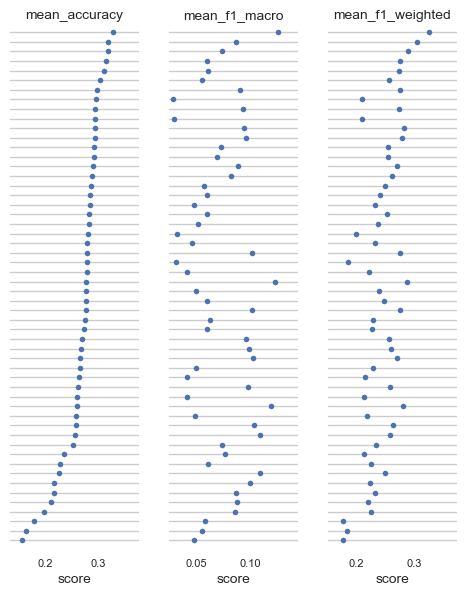

In [16]:
# Scoring metrics we'd like to scan across
scoring_metrics = ['mean_accuracy', 'mean_f1_macro', 'mean_f1_weighted']

# Generate the score report
pbm.plot_score_report(results, scoring_metrics)

Note that the left-most column has been rank-ordered. The other columns have been ordered using these same indices so we can easily compare performance across metrics. We can see that the top scoring model in terms of accuracy scored similarly well in terms of the two other f1 measures. Interestingly, there are also some models which are strong on f1, but relatively mediocre on accuracy. They may be worth exploring more, depending on what we're hoping to achieve in our classification task. 

If we want to inspect a single given model more carefully, and see summary metrics of its performance, we can do that through a variety of standard visualizations, such as confusion matrices or ROC curves. These are demonstrated below, in the section entitled "Applying a model".

## Batch processing
The example above involved a single estimator family, but often we want to try many different kinds of estimators. Additionally, we might be interested in predicting different targets from a given dataset (say, a detection threshold in addition to an odorant class), or making predictions on the basis of different features (molecular fingerprints vs. physicochemical properties). It would therefore be nice to have some batch processing functionality that allows us to tee up a variety combinations of models, features, and targets. 

To streamline the benchmarking process, we can specify lists of prediction targets, feature sets, and estimator pipelines that are fed as arguments to the <span style="font-family: courier new">batch_gridsearchcv</span> method. We also need to create a function that will prepare our prediction targets and feature sets into <span style="font-family: courier new">PyrfumeDataset</span> instances. 

Again, for expediency and for purposes of demonstration, we will just use three classifer algorithms with reduced parameter search spaces. Also for expediency, we will use only the 100 best features in our datasets.

In [17]:
# Batch processing configuration
targets = ['Primary Odor']
feature_sets = ['mordred']

estimators = ['DecisionTreeClassifier', 'RandomForestClassifier', 'BernoulliNB']
reduced_param_grids = [
    {'min_impurity_decrease': [0, 0.001, 0.005], 'max_features': ['sqrt', 'log2']},
    {'n_estimators': [10, 100], 'min_impurity_decrease': [0, 0.001, 0.005], 'max_features': ['sqrt', 'log2']},
    {'alpha': [0.1, 1, 10], 'fit_prior': [True, False], 'binarize': [0.25, 0.5, 0.75]}
]

pipelines = [
    pbm.Model(estimator, param_grid=param_grid)
    for estimator, param_grid in zip(estimators, reduced_param_grids)
]

In [18]:
# Package dataset preparation into a function
def prepare_dataset(archive, target, feature_set):
    # Load behavior data
    behavior = pyrfume.load_data(f'{archive}/behavior_1.csv').sort_index()
    behavior = behavior[~behavior.index.duplicated()]
 
    # Convert to PyrfumeDataset class
    dataset = pbm.PyrfumeDataset(
        archive=archive,
        df=behavior[[target]].rename_axis('CID'),
        feature_set=feature_set,
        task='classification'
    )
    # Drop low frequency labels
    dataset.threshold_labels(min_counts=10)
    
    # Encode descriptors
    dataset.encode_labels()
    
    # Feature selection
    dataset.select_features(
        score_function='f-statistic',
        mode='k_best',
        param=100
    )
    
    return dataset

Before evaluating all our models we can verify that our dataset preparation works as expected.

In [19]:
# Verify that data prepartion works before attempt to batch process
pbm.verify_batch_settings(
    archive=archive,
    targets=targets,
    feature_sets=feature_sets,
    prepare_dataset=prepare_dataset
)

Loading features...
Returned 1332 features for 5026 molecules
--------------------------------------------------
Archive: sharma_2021b
Prediction target: Primary Odor
# molecules: 4918
Molecule features: mordred
# features: 100
ML task: classification
n_splits: 5

     Primary Odor  nHetero   nN
CID                            
4               2      2.0  1.0
19             34      4.0  0.0
49             28      3.0  0.0
51             34      5.0  0.0
58              9      3.0  0.0
--------------------------------------------------


In [25]:
# Batch GridSearchCV over feature set, prediciton targets, and pipeline list
kwargs = {'verbose': 1}

batch_results = pbm.batch_gridsearchcv(
    archive=archive,
    targets=targets,
    feature_sets=feature_sets,
    pipelines=pipelines,
    prepare_dataset=prepare_dataset,
    **kwargs
)


Features = mordred, Prediction target = Primary Odor
--------------------------------------------------
Loading features...
Returned 1332 features for 5026 molecules

DecisionTreeClassifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits

RandomForestClassifier
Fitting 5 folds for each of 12 candidates, totalling 60 fits

MinMaxScaler;BernoulliNB
Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [26]:
# Filter for top scores and dispaly the results
batch_results = pbm.get_best_results(batch_results, include_pipeline_steps=True)
batch_results.head()

accuracy  balanced_accuracy  \
target       features pipeline_string                                         
Primary Odor mordred  DecisionTreeClassifier    0.380233           0.157470   
                      MinMaxScaler;BernoulliNB  0.303781           0.135096   
                      RandomForestClassifier    0.459745           0.198722   

                                                f1_macro  f1_weighted  \
target       features pipeline_string                                   
Primary Odor mordred  DecisionTreeClassifier    0.152451     0.358968   
                      MinMaxScaler;BernoulliNB  0.102024     0.281218   
                      RandomForestClassifier    0.204312     0.433935   

                                                roc_auc_ovr_weighted  \
target       features pipeline_string                                  
Primary Odor mordred  DecisionTreeClassifier                0.785167   
                      MinMaxScaler;BernoulliNB              0.775183   
                      RandomForestClassifier                0.859915   

                                                                            accuracy_param_string  \
target       features pipeline_string                                                               
Primary Odor mordred  DecisionTreeClassifier    decisiontreeclassifier__max_features=sqrt;deci...   
                      MinMaxScaler;BernoulliNB  bernoullinb__alpha=10;bernoullinb__binarize=0....   
                      RandomForestClassifier    randomforestclassifier__max_features=log2;rand...   

                                                                   balanced_accuracy_param_string  \
target       features pipeline_string                                                               
Primary Odor mordred  DecisionTreeClassifier    decisiontreeclassifier__max_features=sqrt;deci...   
                      MinMaxScaler;BernoulliNB  bernoullinb__alpha=0.1;bernoullinb__binarize=0...   
                      RandomForestClassifier    randomforestclassifier__max_features=log2;rand...   

                                                                            f1_macro_param_string  \
target       features pipeline_string                                                               
Primary Odor mordred  DecisionTreeClassifier    decisiontreeclassifier__max_features=sqrt;deci...   
                      MinMaxScaler;BernoulliNB  bernoullinb__alpha=1;bernoullinb__binarize=0.2...   
                      RandomForestClassifier    randomforestclassifier__max_features=log2;rand...   

                                                                         f1_weighted_param_string  \
target       features pipeline_string                                                               
Primary Odor mordred  DecisionTreeClassifier    decisiontreeclassifier__max_features=sqrt;deci...   
                      MinMaxScaler;BernoulliNB  bernoullinb__alpha=0.1;bernoullinb__binarize=0...   
                      RandomForestClassifier    randomforestclassifier__max_features=log2;rand...   

                                                                roc_auc_ovr_weighted_param_string  \
target       features pipeline_string                                                               
Primary Odor mordred  DecisionTreeClassifier    decisiontreeclassifier__max_features=log2;deci...   
                      MinMaxScaler;BernoulliNB  bernoullinb__alpha=0.1;bernoullinb__binarize=0...   
                      RandomForestClassifier    randomforestclassifier__max_features=sqrt;rand...   

                                                                 pipeline_steps  
target       features pipeline_string                                            
Primary Odor mordred  DecisionTreeClassifier         [DecisionTreeClassifier()]  
                      MinMaxScaler;BernoulliNB  [MinMaxScaler(), BernoulliNB()]  
                      RandomForestClassifier         [RandomForestC

The output of <span style="font-family: courier new">batch_gridsearchcv</span> is a DataFrame that contains a row for each prediction target, feature set, pipeline, and parameter set evaluated. Here for easier viewing, we have used the <span style="font-family: courier new">get_best_results</span> method to filter these results to only include the top scoring results (and parameter set) for each scoring metric, prediction target, molecule feature set, and estimator pipeline.

## Data Visualization
We can also view these top scores as a heatmap.

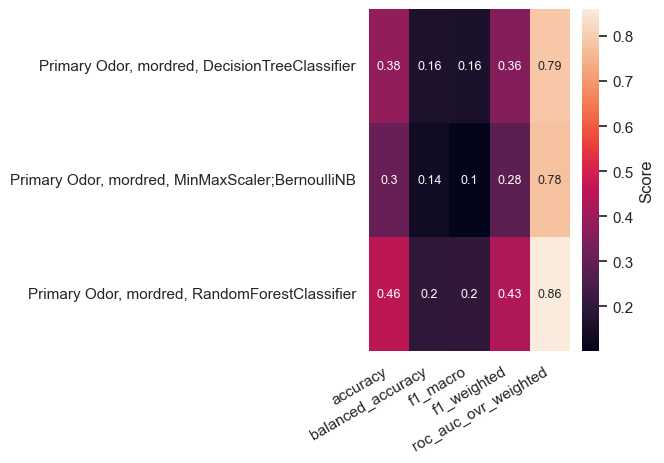

In [22]:
# Display as heatmap
pbm.plot_heatmap(batch_results)

## Applying a model
<span style="font-family: courier new">pyrfume.benchmarking</span> provides methods to make predictions after optimizing parameters using <span style="font-family: courier new">GridSearchCV</span>. To start, we reconstruct a model (i.e. a Pipeline instance) using the results output from <span style="font-family: courier new">batch_gridsearchcv</span>. Below we will recontruct the top-scoring model according to the <span style="font-family: courier new">roc_auc_ovr_weighted</span> score and view the predicted Primary Odor for our training data. (Alternatively, a model can be reconstructed by instead specifying a list of pipeline steps and a parameter string.) Before reconstructing our model, we will prepare a dataset so that our <span style="font-family: courier new">pyrfume.benchmarking</span> instance contains the same (reduced) set of molecule features that were used using model tuning.

In [23]:
# Reconstruct original dataset
dataset = prepare_dataset(archive, target=targets[0], feature_set=feature_sets[0])
dataset.describe()

Loading features...
Returned 1332 features for 5026 molecules
--------------------------------------------------
Archive: sharma_2021b
Prediction target: Primary Odor
# molecules: 4918
Molecule features: mordred
# features: 100
ML task: classification
n_splits: 5

     Primary Odor  nHetero   nN
CID                            
4               2      2.0  1.0
19             34      4.0  0.0
49             28      3.0  0.0
51             34      5.0  0.0
58              9      3.0  0.0
--------------------------------------------------


In [27]:
# Reconstruct top-scoring model
model = pbm.reconstruct_model(
    dataset=dataset,
    results=batch_results,
    metric='roc_auc_ovr_weighted'
)

print(model)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(min_impurity_decrease=0.001))])


In [28]:
# Apply the model
predictions = pbm.apply_model(dataset=dataset, model=model)
predictions.head()

Archive: sharma_2021b
------------------------------
Target: Primary Odor, Features: mordred
Pipeline: RandomForestClassifier(min_impurity_decrease=0.001)
Correct predictions: 2710/4918


,Primary Odor,prediction,is_correct
CID,,,
4,Ammonia,Odorless,False
19,Odorless,Odorless,True
49,Fragrant/Fruity,Bakery,False
51,Odorless,Odorless,True
58,Brown,Odorless,False


Lets look a bit more closely at our top-scoring model with some visualizations. Recall that we created a pipeline object above called 'model' that was the best performing estimator from our grid search. We'll first show a confusion matrix for this model. 

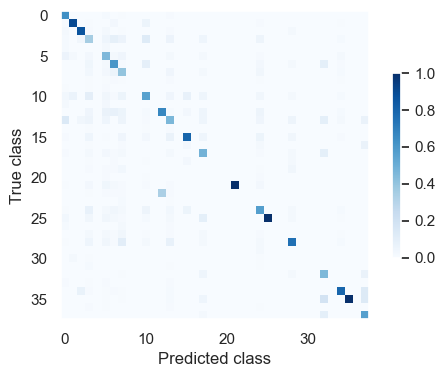

In [29]:
# Plot confusion matrix
pbm.show_confusion_matrix(dataset, model, normalize='pred')

Note that we indicated 'pred' normalization above, which will help us better see errors made within each predicted class. We can also choose 'true' normalization if we want to instead emphasize how well each true class was predicted or 'all' to normalize across all values. The default setting for normalization is <span style="font-family: courier new">None</span>. 

Additionaly, we can plot an ROC curve for the classifier. 

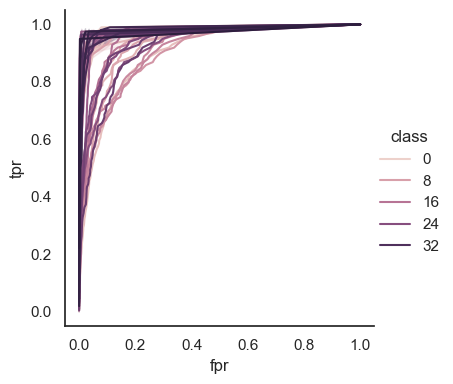

In [32]:
pbm.show_roc_curve(dataset, model)

Note that we actually get a separate ROC curve for each of the predicted classes. Our model seems to perform significantly better for some classes relative to others. 

In regression-type tasks where the target variable is continuous, it doesn't make sense to construct a confusion matrix or an ROC curve. Instead, we typically are interested in fit residuals. To view these, we can call the function <span style="font-family: courier new">show_regressor_performance</span>. We demonstrate its output here on our classifier, for purposes of illustration, even though is not the intended use-case. Because there are a large number of classes (36), we can get away in this case with thinking of this as something like regression. 

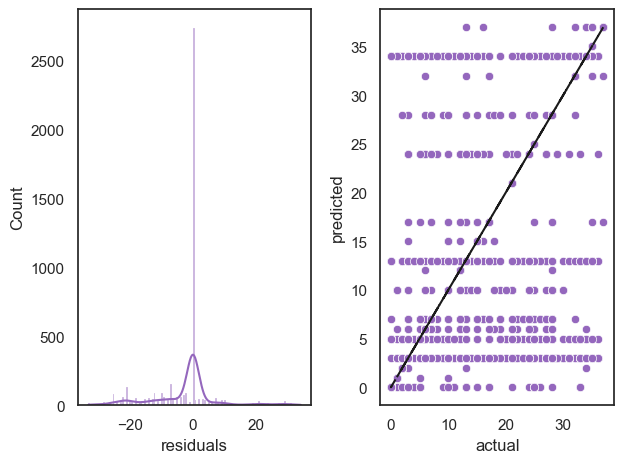

In [33]:
pbm.show_regressor_performance(dataset, model)

Note that the residuals are very heavily concentrated at zero (which is good!). The plot on the right is a little bit misleading, since there are many superimposed points along the diagonal -- in general, the model is making correct predictions. 

Let's now try predicting primary odor for a new set of molecules. In this case, we'll use the odor descriptor data from the [IFRA 2019](https://ifrafragrance.org/priorities/ingredients/glossary) archive. We'll begin by preparing this behavior data into a PyrfumeDataset instance. Note that we will use the feature names from our orignal dataset (the one used to train our model) to create the same subset of 'k-best' features for this new set of molecules.

In [34]:
# Load behavior data
ifra_behavior = pyrfume.load_data('ifra_2019/behavior.csv').sort_index()
ifra_behavior = ifra_behavior[~ifra_behavior.index.duplicated()]

# Convert to PyrfumeDataset class
# 'Descriptor 1' is the primary odor for each molecule and stimulus ID = CID
new_dataset = pbm.PyrfumeDataset(
    archive='ifra_2019',
    df=ifra_behavior[['Descriptor 1']].rename_axis('CID'),
    feature_set='mordred',
    task='classification'
)

# Drop low frequency labels
new_dataset.threshold_labels(min_counts=10)

# Use same features as with the dataset used to train the model
new_dataset.df = new_dataset.df[['Descriptor 1'] + list(dataset.df.columns[1:])]

new_dataset.describe()

Loading features...
Returned 1282 features for 1055 molecules
--------------------------------------------------
Archive: ifra_2019
Prediction target: Descriptor 1
# molecules: 1008
Molecule features: mordred
# features: 100
ML task: classification
n_splits: 5

    Descriptor 1  nHetero   nN
CID                           
107       Floral      2.0  0.0
177       Fruity      1.0  0.0
179    Food Like      2.0  0.0
243       Herbal      2.0  0.0
261     Gourmand      1.0  0.0
--------------------------------------------------


In [35]:
# Apply the model
ifra_predictions = pbm.apply_model(dataset=new_dataset, model=model, label_encoder=dataset.label_encoder)
ifra_predictions.head()

Archive: ifra_2019
------------------------------
Target: Descriptor 1, Features: mordred
Pipeline: RandomForestClassifier(min_impurity_decrease=0.001)
Correct predictions: 36/1008


,Descriptor 1,prediction,is_correct
CID,,,
107,Floral,Aromatic,False
177,Fruity,Odorless,False
179,Food Like,Bakery,False
243,Herbal,Odorless,False
261,Gourmand,Bakery,False


## Summary
In summary, the <span style="font-family: courier new">pyrfume.benchmarking</span> module allows one to compare, evaluate, and visualize the performance of a variety of models. Datasets are teed up as instances of the <span style="font-family: courier new">PyrfumeDataset</span> class, and model pipelines are populated and specified via the <span style="font-family: courier new">Model</span> class. These generate <span style="font-family: courier new">GridSearchCV</span> objects which can be inspected, filtered down, and visualized using benchmarking functions demonstrated above. 